# Домашняя работа 4. Кластеризация.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #4: Name Surname`. Если тема будет неправильная, то задание не будет проверено.

**Дедлайн**: 19.11.2017 00:00 OMSK

    После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

**Рассылка решений**: 23.11.2017 17:00 OMSK

    После рассылки задания совсем не имеют веса.

### Полезная литература

- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

In [ ]:
#!pip3 install numpy pandas scipy sklearn matplotlib seaborn Pillow scikit-image

## 1. Изображения (6 баллов)

С помощью алгоритмов кластеризации можно уменьшить число цветов в изображении. В данном случае будут кластеризоваться похожие пиксели. Такой подход позволяет перейти к суперпиксельному представлению изображений, которое является более компактным и используется в задачах компьютерного зрения.

Загрузим картинку `data/bird.jpg` с помощью scikit-image и выведите ее с помощью matplotlib.

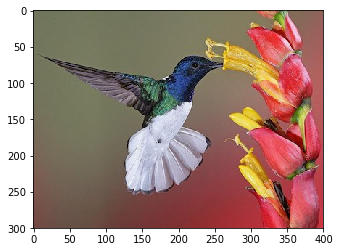

In [1]:
%matplotlib inline
from skimage.io import imread
from matplotlib import pyplot as plt
import numpy as np

img = imread("data/bird.jpg")
plt.imshow(img)

### 1.1 Scale (0.5 балла)

Если вы посмотрите на содержимое numpy массива, в котором хранится изображение, то увидите, что там будут числа от 0 до 255. Нам лучше перейти к числам от 0 до 1. 

**Преобразуйте вашу матрицу, как сказано выше.**

**Hint**: Это можно сделать с помощью функции `skimage.img_as_float`.

In [2]:
from skimage import img_as_float
img_f = img_as_float(img)
img_f.shape

(300, 400, 3)

### 1.2 Reshape (1 балл)

Мы получили матрицу размера `(300, 400, 3)`. Нам это не подходит. Чтобы запустить kMeans нам нужно иметь много-много объектов и 3 признака - значение яркости пикселя в канале Red, Green и Blue. 

**Преобразуйте матрицу так, чтобы получилась матрица размера `(120000, 3)`. **

**Hint**: Вам пригодятся функции: `np.ravel` и `np.vstack`.

In [3]:
img_f2 = img_f.reshape(120000,3)
img_f2.shape

(120000, 3)

### 1.3 Train (0.5 балла)

Отлично. У нас есть подготовленные данные. Теперь мы будем находить кластеры похожих пикселей по цвету. Для этого создайте KMeans для, например, 8 цветов. **Обучите модель** (может занять около 10 секунд). С помощью магического макроса `%time` **покажите, сколько времени у вас занимало обучение**.

In [32]:
%%time
import sklearn
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=8)
clf.fit(img_f2)

Wall time: 22.3 s


### 1.4 Draw centroids (1 балл)

**Нарисуйте с помощью imshow центры кластеров**: будет 8 пикселей со средним цветом по всему кластеру. 
Это называется цветовой палитрой. 

**Hint**: reshape в 3 мерный массив, так как у вас будет 2-мерный

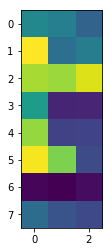

In [33]:
center=clf.cluster_centers_
#plt.imshow(center[:].reshape([8,3]))
plt.imshow(center);

### 1.5 Draw final image (3 балла)

У нас есть значения цвета для каждого центра кластера. Каждый пиксель в результате обучения KMeans теперь имеет свой лейбл кластера. Значит мы можем заменить все пиксели на соответсвующие им центры класетров. Проведите это преобразование и выведите 8-цветное изображение.

**Hints**: `labels_`, `reshape`, `copy`, логические маски в numpy `arr[arr == 1] = 0`. У меня это 7 строк кода.

In [34]:
cluster_labels = clf.fit_predict(img_f2)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


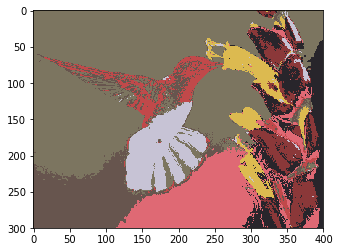

In [35]:
from skimage import img_as_ubyte
img_f8=np.copy(img_f2)
for i in range(cluster_labels.shape[0]): 
    img_f8[i]=center[cluster_labels[i]]
img_8=img_as_ubyte(img_f8.reshape(300,400,3));
plt.imshow(img_8);

## 2. Центры кластеров (6 баллов)

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare. Полный датасет доступен здесь: https://archive.org/details/201309_foursquare_dataset_umn. Но в `../../data/checkins.csv.gz` я подготовил данные и оставил только 100000 жлементов, иначе бы KMeans обучался пол дня.

Найдем на Google Maps координаты офисов компании:

```
33.751277, -118.188740 (Los Angeles)
25.867736, -80.324116 (Miami)
51.503016, -0.075479 (London)
52.378894, 4.885084 (Amsterdam)
39.366487, 117.036146 (Beijing)
-33.868457, 151.205134 (Sydney)
```

###  2.0 Read data (0.5 балла): 
**Загрузите датасет `checkins.csv.gz`. Выведите его размер, первые 5 строк таблицы, статистическиую сводку(describe) **

In [1]:
import pandas as pd

df = pd.read_csv('data/checkins.csv.gz', compression='gzip', na_values='?')
print(df.shape)
print(df.head())
df.describe()

(100000, 2)
    latitude   longitude
0  38.895112  -77.036366
1  33.800745  -84.410520
2  45.523452 -122.676207
3  40.764462 -111.904565
4  33.448377 -112.074037


,latitude,longitude
count,100000.000000,100000.000000
mean,36.886388,-89.396849
std,8.351517,35.579317
min,-45.031162,-159.670833
25%,33.494170,-112.074037
50%,38.646991,-87.743938
75%,40.740389,-75.163789
max,67.631479,174.908056


###  2.1 MeanShift (1 балл): 
Для данной задачи мы не знаем сколько кластеров вообще существует, и есть ли они, поэтому воспользуемся методом, который сам находит нужное количество кластеров. Используйте `MeanShift`, указав `bandwidth=0.1`, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах. Документацию по нему вы можете найти в документации SKlearn [тут](http://scikit-learn.org/stable/modules/clustering.html#mean-shift).

**Обучите кластеризатор на всех данных.** Выполнение в 4 потока на i5 заняло 2 минуты.

In [3]:
import numpy as np
from sklearn.cluster import MeanShift
ms = MeanShift(bandwidth=0.1)
ms.fit(df)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 3230


### 2.2 Visualization (0.5 балла): 
**Визуализируйте с помощью matplotlib все точки из датасета** так, чтобы они были разукрашены в соответсвии с кластером к которому они принадлежат. **Добавьте на ваш график ещё точки расположений офисов**, сделайте их большими и красными, чтобы было видно. Рисовать каким-то образом карту мира под точками НЕ надо.

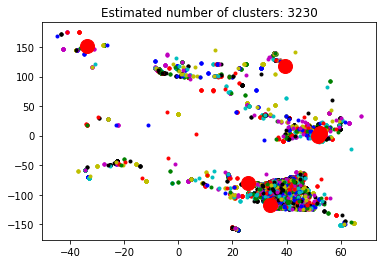

In [28]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()
ofs = [[33.751277, -118.188740],[25.867736, -80.324116],[51.503016, -0.075479],
       [52.378894, 4.885084],[39.366487, 117.036146],[-33.868457, 151.205134]]

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(df[my_members][df.columns[0]], df[my_members][df.columns[1]], col + '.')
   # plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
for of in ofs :
    plt.plot(of[0], of[1], 'ro', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

###  2.3 Filter clusters (2 балла): 
Как видим на графике, некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения. 

**Выведите количество кластеров, которое удовлетворяет этому условию.**

**Hint**: `itertools.groupby`

In [29]:
from itertools import groupby
from itertools import filterfalse
hist_labels = [(key,len(list(gr))) for key, gr in groupby(sorted(labels))]
hist_labels_filt = filterfalse(lambda x: x[1]<=15, hist_labels)
labels_filt = [key for key, v in hist_labels_filt]
len(labels_filt)

592

###  Задание 2.4 (2 балла): 
Как мы помним, необходимо разместить только 20 баннеров близ офисов компании. Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

**Выведите эти 20 центров кластеров, отсортрованных по возрастанию расстояния до ближайшего офиса.**

**Hint:** Для вычисления расстояния вы можете использовать обычную евклидову метрику и предполагать, что земля плоская. А можете использовать `geopy.distance.vincenty` если поймёте как.

In [13]:
! pip install geopy

In [37]:
from geopy.distance import vincenty
distances=[]
for elem in labels_filt :
    cluster_center = cluster_centers[elem]
    distances.append([min([vincenty(cluster_center, of).meters for of in ofs]), cluster_center])
len(distances)

592

In [43]:
distances_sort = sorted(distances)
distances_sort[:20]

[[823.4439405644299, array([ 52.37296399,   4.89231722])],
 [868.7548890811112, array([ -33.86063043,  151.20477593])],
 [2499.8389367887366, array([ 25.84567226, -80.3188906 ])],
 [3475.8459456398737, array([ 51.50299126,  -0.12553729])],
 [7473.232758059828, array([  33.80987796, -118.14892381])],
 [13989.508525635183, array([ 25.78581242, -80.21793804])],
 [18446.96585816007, array([ 25.70534972, -80.28342874])],
 [19965.422193191487, array([  33.88832534, -118.04892817])],
 [20083.48182929834, array([ 26.01009825, -80.19999059])],
 [20972.68871913541, array([  33.87298601, -118.36209115])],
 [24618.59140376059, array([  33.97257482, -118.16837067])],
 [28509.66431087388, array([  33.81730643, -117.89124917])],
 [30052.96080851433, array([ 26.13884379, -80.33434684])],
 [30781.408060009504, array([  33.98393587, -118.00740497])],
 [31753.935186626823, array([  33.67430266, -117.85878927])],
 [32558.26328192169, array([ 26.12086266, -80.15890668])],
 [34733.546602738235, array([  34.

Координата центра кластера ближайшего к какому-то из офисов компании должны быть `(52.37296399032261, 4.8923172225806466)`. Если у вас не так, то считайте, что вы сделали что-то неправильно. 